<a href="https://colab.research.google.com/github/ssudhanshu488/image_background_removal/blob/main/background_removal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy
import cv2
import os
import pandas as pd
import matplotlib.pyplot as plt
!pip install -U -q segmentation-models
!pip install -q tensorflow==2.2.1
!pip install -q keras==2.5
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"
from segmentation_models import Unet
from segmentation_models.metrics import IOUScore
from segmentation_models.losses import JaccardLoss
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.2 MB/s eta 0:00:00
ERROR: Could not find a version that satisfies the requirement tensorflow==2.2.1 (from versions: 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.8.4, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1, 2.9.2, 2.9.3, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0, 2.10.1, 2.11.0rc0, 2.11.0rc1, 2.11.0rc2, 2.11.0, 2.11.1, 2.12.0rc0, 2.12.0rc1, 2.12.0, 2.12.1, 2.13.0rc0, 2.13.0rc1, 2.13.0rc2, 2.13.0, 2.13.1, 2.14.0rc0, 2.14.0rc1, 2.14.0, 2.14.1, 2.15.0rc0, 2.15.0rc1, 2.15.0, 2.15.0.post1, 2.15.1, 2.16.0rc0, 2.16.1)
ERROR: No matching distribution found for tensorflow==2.2.1
ERROR: Could not find a version that satisfies the requirement keras==2.5 (from versions: 0.2.0, 0.3.0, 0.3.1, 0.3.2, 0.3.3, 1.0.0, 1.0.1, 1.0.2, 1.0.3, 1.0.4, 1.0.5, 1.0.6, 1.0.7, 1.0.8, 1.1.0, 1.1.1, 1.1.2, 1.2.0, 1.2.1, 1.2.2, 2.0.0, 2.0.1, 2.0.2, 2.0.3, 2.0.4, 2.0.5, 2.0.6, 2.0.7, 2.0.8, 2.0.9, 2.1.0, 2.1.1, 2.1.2, 2.1.3, 2.1.4, 2.1.5, 2.1

In [2]:
! pip install -q kaggle

In [ ]:
! chmod 600 /content/kaggle.json

In [3]:
!kaggle datasets download -d hngngn/portrait-segmentation-128x128

Dataset URL: https://www.kaggle.com/datasets/hngngn/portrait-segmentation-128x128
License(s): other
 98% 713M/725M [00:12<00:00, 146MB/s]
100% 725M/725M [00:12<00:00, 59.2MB/s]


In [4]:
!unzip portrait-segmentation-128x128.zip

Streaming output truncated to the last 5000 lines.
  inflating: ytrain/13698.png        
  inflating: ytrain/13699.png        
  inflating: ytrain/13700.png        
  inflating: ytrain/13701.png        
  inflating: ytrain/13702.png        
  inflating: ytrain/13703.png        
  inflating: ytrain/13704.png        
  inflating: ytrain/13705.png        
  inflating: ytrain/13706.png        
  inflating: ytrain/13707.png        
  inflating: ytrain/13708.png        
  inflating: ytrain/13709.png        
  inflating: ytrain/13710.png        
  inflating: ytrain/13711.png        
  inflating: ytrain/13712.png        
  inflating: ytrain/13713.png        
  inflating: ytrain/13714.png        
  inflating: ytrain/13715.png        
  inflating: ytrain/13716.png        
  inflating: ytrain/13717.png        
  inflating: ytrain/13718.png        
  inflating: ytrain/13719.png        
  inflating: ytrain/13720.png        
  inflating: ytrain/13721.png        
  inflating: ytrain/13722.png        

# Data Preprocessing

In [5]:
import os
import shutil
from sklearn.model_selection import train_test_split

xtrain_dir = '/content/xtrain'
ytrain_dir = '/content/ytrain'
xval_dir = '/content/xval'
yval_dir = '/content/yval'

if not os.path.exists(xval_dir):
    os.makedirs(xval_dir)
if not os.path.exists(yval_dir):
    os.makedirs(yval_dir)

x_files = os.listdir(xtrain_dir)
y_files = os.listdir(ytrain_dir)

x_files.sort()
y_files.sort()

x_train_files, x_val_files, y_train_files, y_val_files = train_test_split(x_files, y_files, test_size=0.2, random_state=42)

def move_files(files, src_dir, dst_dir):
    for file in files:
        src = os.path.join(src_dir, file)
        dst = os.path.join(dst_dir, file)
        shutil.move(src, dst)

move_files(x_val_files, xtrain_dir, xval_dir)
move_files(y_val_files, ytrain_dir, yval_dir)

In [6]:
path = '/content'

img_size = (128,128)
batch_size = 64

image_datagen = ImageDataGenerator(rescale=1./255)
mask_datagen = ImageDataGenerator(rescale=1./255)

#Data generator for training set
train_image_generator = image_datagen.flow_from_directory(
                        path,
                        classes=['xtrain'],
                        target_size=img_size,
                        batch_size=batch_size,
                        class_mode=None,
                        seed=1,
                        shuffle=False,
                        color_mode='rgb')

train_mask_generator = mask_datagen.flow_from_directory(
                        path,
                        classes=['ytrain'],
                        target_size=img_size,
                        batch_size=batch_size,
                        class_mode=None,
                        seed=1,
                        shuffle=False,
                        color_mode='grayscale')

train_generator = zip(train_image_generator, train_mask_generator)

#Data generator for validation set
val_image_generator = image_datagen.flow_from_directory(
                        path,
                        classes=['xval'],
                        target_size=img_size,
                        batch_size=batch_size,
                        class_mode=None,
                        seed=1,
                        shuffle=False,
                        color_mode='rgb')

val_mask_generator = mask_datagen.flow_from_directory(
                        path,
                        classes=['yval'],
                        target_size=img_size,
                        batch_size=batch_size,
                        class_mode=None,
                        seed=1,
                        shuffle=False,
                        color_mode='grayscale')

validation_generator = zip(val_image_generator, val_mask_generator)

#Data generator for test set
test_image_generator = image_datagen.flow_from_directory(
                        path,
                        classes=['xtest'],
                        target_size=img_size,
                        batch_size=batch_size,
                        class_mode=None,
                        seed=1,
                        shuffle=False,
                        color_mode='rgb')

test_mask_generator = mask_datagen.flow_from_directory(
                        path,
                        classes=['ytest'],
                        target_size=img_size,
                        batch_size=batch_size,
                        class_mode=None,
                        seed=1,
                        shuffle=False,
                        color_mode='grayscale')

test_generator = zip(test_image_generator, test_mask_generator)

Found 14958 images belonging to 1 classes.
Found 14958 images belonging to 1 classes.
Found 3740 images belonging to 1 classes.
Found 3740 images belonging to 1 classes.
Found 3740 images belonging to 1 classes.
Found 3740 images belonging to 1 classes.


# Model Selection (here I have unet model as VGG is already pretrained so we do not have to retrain it)

In [7]:
model = Unet(encoder_freeze=True)
model.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, None, None, 64)       1792      ['input_1[0][0]']             
                                                                                                  
 block1_conv2 (Conv2D)       (None, None, None, 64)       36928     ['block1_conv1[0][0]']        
                                                                                                  
 block1_pool (MaxPooling2D)  (None, None, None, 64)       0         ['block1_conv2[0][0]']        
                             

# Model Training (I have made callbacks which can save checkpoint of every epoch after its completion in google drive so that I don't have to rerun model.fit if session gets disconnected)

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
import os
import tensorflow as tf

checkpoint_dir = '/content/drive/MyDrive/check_points'
latest_checkpoint = tf.train.latest_checkpoint(checkpoint_dir)
print(f"Latest checkpoint: {latest_checkpoint}")

Latest checkpoint: /content/drive/MyDrive/check_points/cp-0004.ckpt


In [8]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=1)

In [12]:
checkpoint_path = os.path.join(checkpoint_dir, 'cp-{epoch:04d}.ckpt')
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    verbose=1,
    save_freq='epoch'
)

In [13]:
model.compile(loss = JaccardLoss(per_image=True), optimizer="adam", metrics=IOUScore(per_image=True))

In [14]:
model.load_weights(latest_checkpoint)

In [ ]:
!pip install ipython-autotime
%load_ext autotime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 5.9 MB/s eta 0:00:00
time: 353 µs (started: 2024-06-09 06:38:06 +00:00)


In [15]:
model_history = model.fit(train_generator, steps_per_epoch = 277, validation_data=validation_generator,
           validation_steps = 16, batch_size=64, epochs=5, initial_epoch=int(latest_checkpoint.split('-')[-1].split('.')[0]), callbacks=[callback, checkpoint_callback])

Epoch 5/5
277/277 [==============================] - ETA: 0s - loss: 0.0327 - iou_score: 0.9673 
Epoch 5: saving model to /content/drive/MyDrive/check_points/cp-0005.ckpt
277/277 [==============================] - 11221s 40s/step - loss: 0.0327 - iou_score: 0.9673 - val_loss: 0.0394 - val_iou_score: 0.9606


In [16]:
model.evaluate(test_generator, batch_size=64, steps=59, verbose=1)

59/59 [==============================] - 1317s 22s/step - loss: 0.0285 - iou_score: 0.9714


[0.028496069833636284, 0.9714102149009705]

# Saving the Model

In [17]:
import os

model_save_dir = '/content/drive/MyDrive/final_background_removal'
os.makedirs(model_save_dir, exist_ok=True)
model_save_path = os.path.join(model_save_dir, 'my_model')

In [18]:
model.save(model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to /content/drive/MyDrive/final_background_removal/my_model


# Prediction

In [19]:
loss_func = JaccardLoss(per_image=True)
metric = IOUScore(per_image=True)

In [21]:
model = tf.keras.models.load_model('/content/drive/MyDrive/final_background_removal/my_model', compile=False)

In [22]:
model.compile(loss = loss_func, optimizer="adam", metrics=[metric])

In [25]:
import numpy as np
path_test_img = '/content/sudhanshuimage.jpg'

img_test_orig = cv2.imread(path_test_img)
h, w = img_test_orig.shape[0:2]

img_test_resized = cv2.resize(img_test_orig, (128,128))
img_test = np.asarray(img_test_resized)/255.0
img_test = img_test[np.newaxis,...]
print(img_test.shape)

(1, 128, 128, 3)


In [26]:
pred_img = model.predict(img_test)
print(pred_img.shape)

1/1 [==============================] - 3s 3s/step
(1, 128, 128, 1)


In [27]:
pred_img = np.squeeze(pred_img)

result = img_test_resized.copy()
result = cv2.cvtColor(result, cv2.COLOR_BGR2RGBA)

pred_img_copy = pred_img.copy()
pred_img_copy[pred_img_copy<0.5] = 0
pred_img_copy[pred_img_copy>=0.5] = 255
print("Shape of result: " , result.shape)
print("Shape of pred_img_copy: " , pred_img_copy.shape)

result[:, :, 3] = pred_img_copy
result = cv2.resize(result, (h,w))
print("bg_removed shape: " , result.shape)

Shape of result:  (128, 128, 4)
Shape of pred_img_copy:  (128, 128)
bg_removed shape:  (1080, 1080, 4)


Preprocessed image shape: (1, 128, 128, 3)
1/1 [==============================] - 1s 1s/step
Predicted mask shape: (1, 128, 128, 1)
Post-processed mask shape: (5184, 3456)
Final output shape: (5184, 3456, 4)


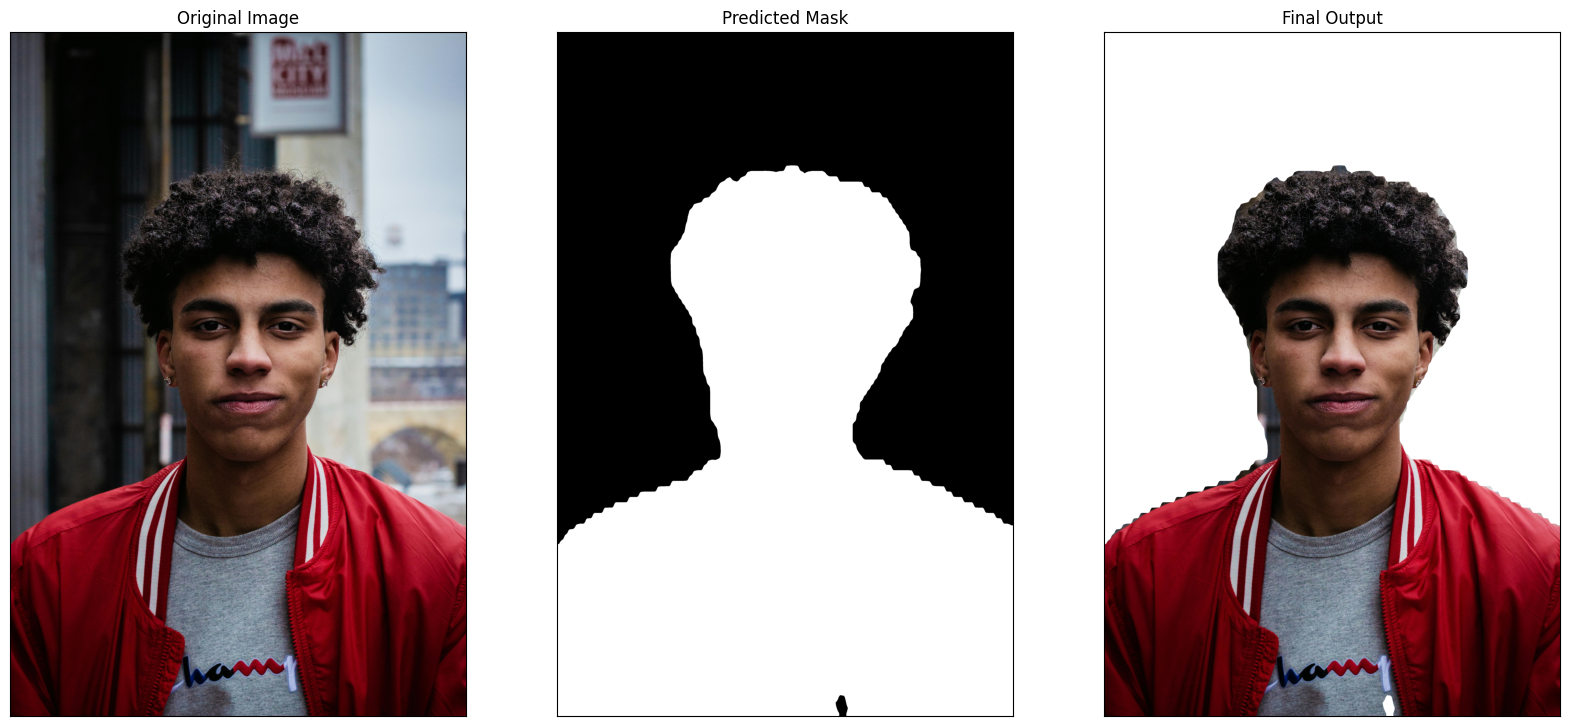

In [32]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt


# Load the model
loss_func = JaccardLoss(per_image=True)
metric = IOUScore(per_image=True)
model = tf.keras.models.load_model('/content/drive/MyDrive/final_background_removal/my_model', compile=False)
model.compile(loss=loss_func, optimizer="adam", metrics=[metric])

# Function to preprocess the input image
def preprocess_image(image_path, target_size):
    image = cv2.imread(image_path)
    original_size = image.shape[:2]
    image_resized = cv2.resize(image, target_size)
    image_resized = image_resized / 255.0
    image_resized = np.expand_dims(image_resized, axis=0)
    return image_resized, original_size

# Function to post-process the predicted mask
def postprocess_mask(pred_mask, original_size):
    pred_mask = (pred_mask * 255).astype(np.uint8)
    pred_mask = cv2.resize(pred_mask, (original_size[1], original_size[0]))
    pred_mask[pred_mask < 128] = 0
    pred_mask[pred_mask >= 128] = 255
    return pred_mask

# Path to the test image
path_test_img = '/content/mansample.jpg'

# Preprocess the image
img_test, original_size = preprocess_image(path_test_img, (128, 128))
print(f"Preprocessed image shape: {img_test.shape}")

# Make prediction
pred_img = model.predict(img_test)
print(f"Predicted mask shape: {pred_img.shape}")
pred_img = np.squeeze(pred_img, axis=0)

# Post-process the predicted mask
pred_img = postprocess_mask(pred_img, original_size)
print(f"Post-processed mask shape: {pred_img.shape}")

# Create RGBA output image
result = cv2.imread(path_test_img)
result = cv2.cvtColor(result, cv2.COLOR_BGR2BGRA)
result[:, :, 3] = pred_img

print(f"Final output shape: {result.shape}")

# Display the original image, predicted mask, and final output
fig = plt.figure(figsize=(20, 15))

rows = 1
columns = 3

fig.add_subplot(rows, columns, 1)
plt.imshow(cv2.cvtColor(cv2.imread(path_test_img), cv2.COLOR_BGR2RGB))
plt.xticks([]), plt.yticks([])
plt.title("Original Image")

fig.add_subplot(rows, columns, 2)
plt.imshow(pred_img, cmap='gray')
plt.xticks([]), plt.yticks([])
plt.title("Predicted Mask")

fig.add_subplot(rows, columns, 3)
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGRA2RGBA))
plt.xticks([]), plt.yticks([])
plt.title("Final Output")

plt.show()


In [33]:
output_path = '/content/drive/MyDrive/final_background_removal/output_image.png'
cv2.imwrite(output_path, result)
print(f"Output image saved at: {output_path}")

Output image saved at: /content/drive/MyDrive/final_background_removal/output_image.png
